Install Necessary Libraries.

In [ ]:
!pip install munkres
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 2.2 MB/s eta 0:00:00


Mount Google Drive and set directory for results.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Thesis/exchangeratesv4.csv'

Mounted at /content/drive


Import all necessary packages.

In [ ]:
import argparse

import matplotlib.pyplot as plt
from munkres import Munkres
from sklearn.manifold import TSNE
import torch
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import math
import gzip
import scipy.io as scio
from sklearn import mixture

from torch.utils.data import DataLoader, TensorDataset


Data Pre-processing. All data sourced from LSEG Workspace.

In [ ]:
# Read the original CSV file
import torch
import pandas as pd
import torch.optim as optim
import numpy as np
import math
import gzip
import scipy.io as scio
from sklearn import mixture
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
#original_df = pd.read_csv("2024_3_20_MexicanCrashRefinitiv.csv")


exchange_df = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)

MSCI_df = exchange_df.iloc[:, -10:]*1e-3
MSCI_df.iloc[:, -6] *= 1e-7
MSCI_df.iloc[:, -2] *= 1e-3

exchange_df = exchange_df.iloc[:, :-10] #getting rid of MSCI indices right now

returns_df = exchange_df.diff() / exchange_df.shift(1)
returns_df = returns_df.iloc[:, :] * 1e3
returns_df.fillna(0, inplace = True)
returns_df.replace([np.inf, -np.inf], 0, inplace=True)

returns_df = pd.concat([returns_df, MSCI_df], axis=1)


cutoff_date = pd.to_datetime('1994-12-01')
cutoff_date2 = pd.to_datetime('1996-06-01')

# Split data into training and test sets
X_train = returns_df[returns_df.index < cutoff_date]
X_test = returns_df[returns_df.index >= cutoff_date]
X_test_alt = returns_df[returns_df.index >= cutoff_date2]

X_train_tensor = torch.from_numpy(X_train.values).float()
X_test_tensor = torch.from_numpy(X_test.values).float()

train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)


Set constants.

In [ ]:
dim_c = 5
dim_z = 5
dim_x = X_train.shape[0]

batch_size = 6000

Define and train econometric benchmark model, using Principal Components Analysis, Gaussian Mixture Model and Logistic Regression.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


IndexError: list index out of range

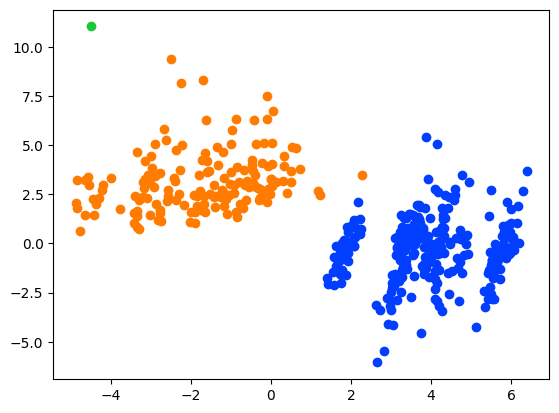

In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
class PCAKM():
    """Econometric style classifier.

    Args:
    dim_c (int): Number of clusters.
    dim_z (int): Dimension of observed data.
    dim_x (int): Dimension of latent space.
    """
    def __init__(self, dim_x, dim_z, dim_c):
      super(PCAKM, self).__init__()
      self.x_means = pd.DataFrame()

      self.PCA = PCA(n_components = dim_z)
      self.kmeans = KMeans(n_clusters=dim_c, random_state=0)
      self.scaler = StandardScaler()
      self.log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

    def train(self, x_train, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
      principal_components = self.PCA.fit_transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      cluster_assignments = self.kmeans.fit_predict(principal_df.iloc[:, :])
      self.z_means = self.kmeans.cluster_centers_

      # Create a DataFrame with the original X training set and cluster assignments
      X_train_with_clusters = pd.concat([x_train, pd.Series(cluster_assignments, name='today_clusters')], axis=1)
      self.x_means = x_train.groupby(cluster_assignments).mean()
      self.x_means.fillna(0)

      scaled_data['today_clusters'] = cluster_assignments
      y = cluster_assignments[1:]
      self.log_reg.fit(scaled_data[:-1], y)
      coefficients = self.log_reg.coef_

      # Get unique cluster assignments
      unique_clusters = np.unique(cluster_assignments)
      palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

      # Plot data points for each cluster separately
      for cluster in unique_clusters:
          cluster_indices = cluster_assignments == cluster
          plt.scatter(principal_df['PC1'][cluster_indices], principal_df['PC2'][cluster_indices],
                      color=palette[cluster], label=f'Cluster {cluster}')

      plt.xlabel('Principal Component 1')
      plt.ylabel('Principal Component 2')
      plt.title('PCA vs K Means Clusters')
      plt.legend()
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/latentspacePCAKM.png")
      plt.show()


      # Plot coefficients for each cluster within a loop
      for i, coef in enumerate(coefficients):
        sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort based on absolute value
        sorted_coefficients = coef[sorted_indices]
        sorted_column_names = scaled_data.columns[sorted_indices]

        # Truncate after the top 10 contributors
        sorted_coefficients = sorted_coefficients[:dim_z]
        sorted_column_names = sorted_column_names[:dim_z]

        # Calculate figure size based on the number of features
        fig_height = max(8, len(sorted_column_names) * 0.4)
        plt.figure(figsize=(10, fig_height))  # Increase the figure size

        bar_height = 0.4  # Set a fixed bar height

        plt.barh(sorted_column_names, sorted_coefficients, height=bar_height)  # Set bar height
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.title('Top 5 Contributors for K Means Cluster {}'.format(i))

        # Adjust the y-axis ticks
        tick_positions = np.arange(len(sorted_column_names)) * 1.2
        plt.yticks(tick_positions, sorted_column_names)

        images_dir = '/content/drive/My Drive/Thesis/Images'
        plt.savefig(f"{images_dir}/PCAKM_log_model_coefficients_cluster{i}.png")
        plt.show()

    def test(self, x_test, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.transform(x_test), index = x_test.index, columns = x_test.columns)
      principal_components = self.PCA.transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      scaled_data['today_clusters'] = self.kmeans.predict(principal_df.iloc[:, :])
      scaled_data['tomorrow_clusters'] = self.log_reg.predict(scaled_data)

      y_pred = np.array([self.x_means.iloc[i] for i in scaled_data['tomorrow_clusters']])
      accuracy = accuracy_score(scaled_data['today_clusters'], scaled_data['tomorrow_clusters'])
      print("Accuracy:", accuracy)
      # Compute confusion matrix
      conf_matrix = confusion_matrix(scaled_data['today_clusters'], scaled_data['tomorrow_clusters'])
      # Plot confusion matrix
      plt.figure(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
      plt.title("PCA K Means Confusion Matrix")
      plt.xlabel("Predicted Labels")
      plt.ylabel("True Labels")
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/PCAKMconfusion_matrix.png")
      plt.show()
      return y_pred

# Instantiate PCAGMM_model and train/test
PCAKM_model = PCAKM(dim_x, dim_z, dim_c)
PCAKM_model.train(X_train, dim_x, dim_z, dim_c)
y_pred = PCAKM_model.test(X_test, dim_x, dim_z, dim_c)

# Calculate mean squared error
mse = mean_squared_error(X_test, y_pred)
pred_exchange_rates = X_test.iloc[:20, 2]
actual_exchange_rates = y_pred[:20, 2]

# Plotting the immediate crisis in December 1994
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_exchange_rates)),pred_exchange_rates, marker='o', color='red', markersize=5, linestyle='-',label = 'predicted')
plt.plot(range(len(pred_exchange_rates)), actual_exchange_rates, marker='o', color='blue', markersize=5, linestyle='-', label = 'actual')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.title('PCAKM Predicted vs Actual Exchange Rates')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.xticks(range(len(pred_exchange_rates))[::4], X_test.index[:20:4])
plt.savefig(f"{images_dir}/PCAKMcomparisonpng")
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
plt.legend()
print("Mean Squared Error:", mse)



Create and train economic benchmark model using Principal Components Analysis, Hidden Markov Model and Multinomial Logistic Regression.

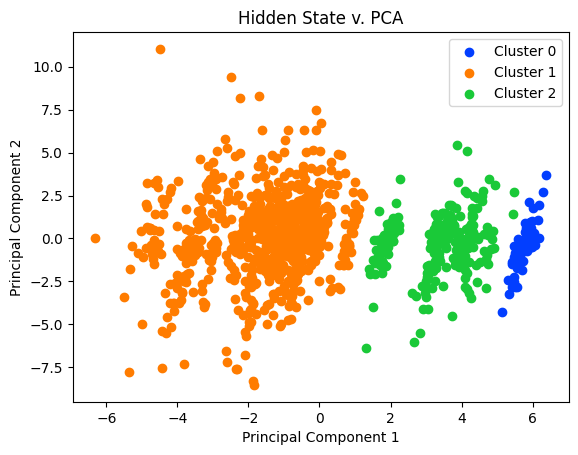

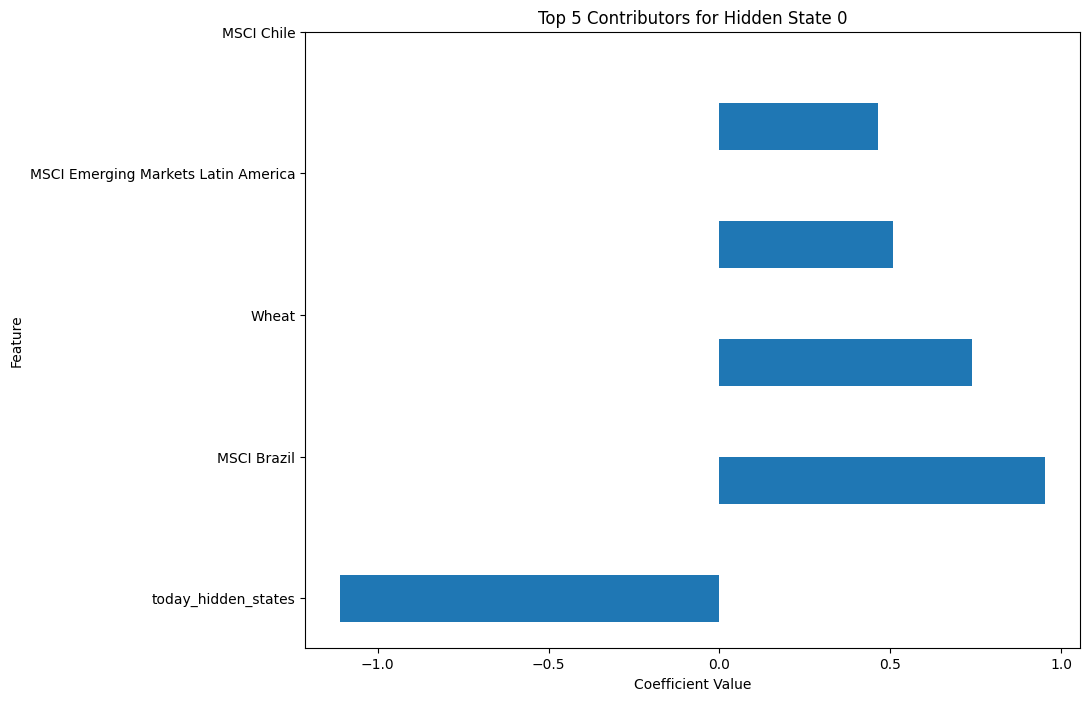

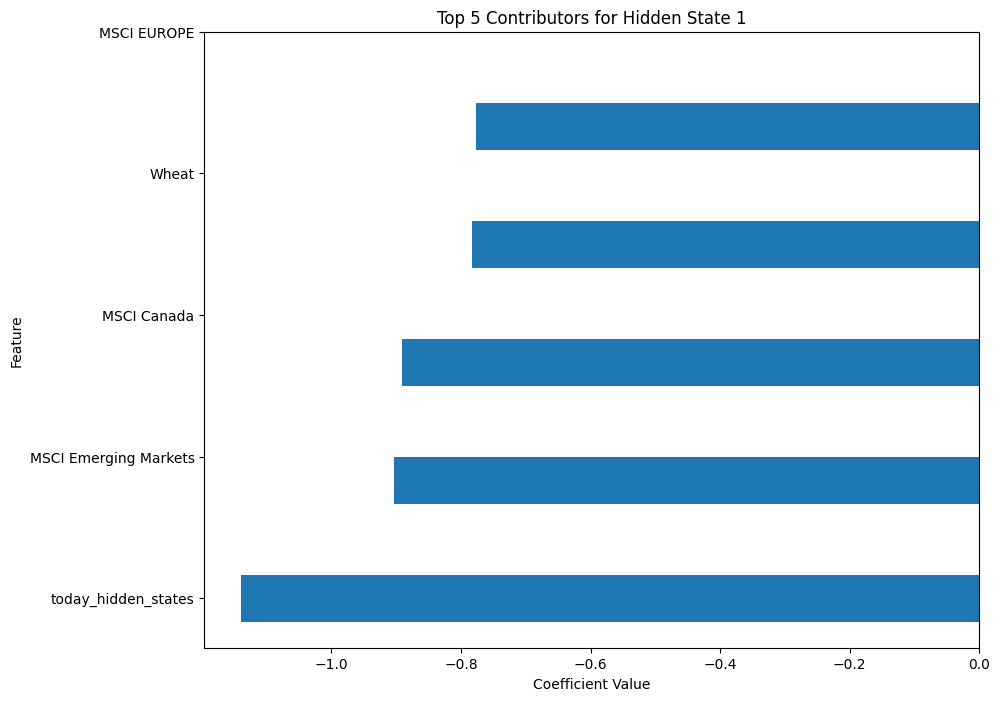

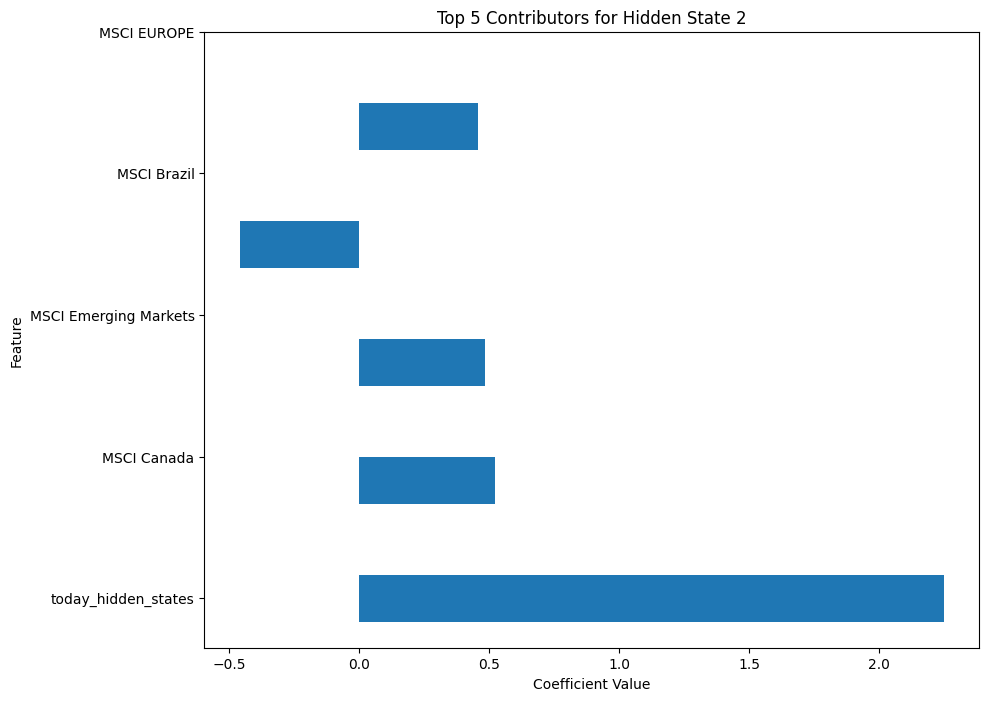

Accuracy: 0.5544090056285178


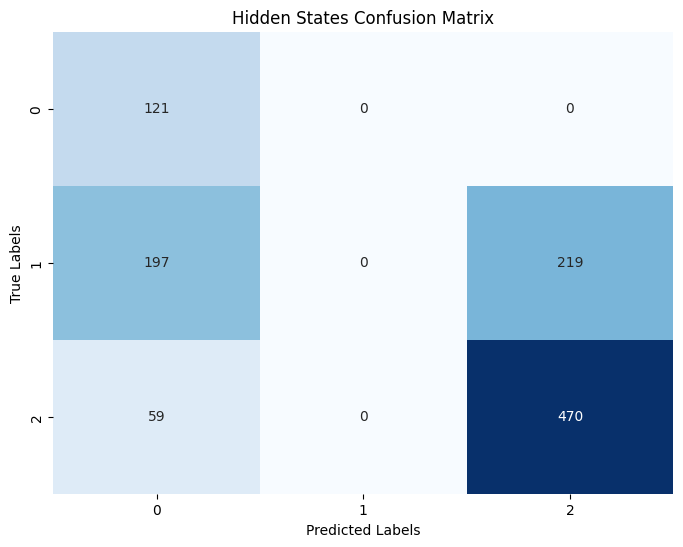

Mean Squared Error: 9073.846440238296


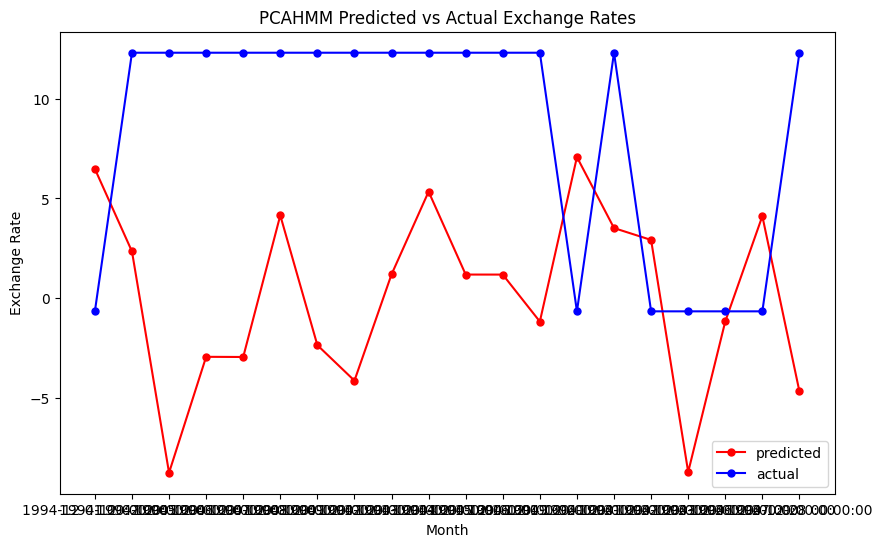

In [ ]:
from hmmlearn.hmm import GaussianHMM
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
class PCAHMM():
    """Econometric style classifier.

    Args:
    dim_c (int): Number of clusters.
    dim_z (int): Dimension of observed data.
    dim_x (int): Dimension of latent space.
    """
    def __init__(self, dim_x, dim_z, dim_c):
        super(PCAHMM, self).__init__()
        self.PCA = PCA(n_components=dim_z)
        self.HMM = GaussianHMM(n_components=dim_c, n_iter=100)  # Use GaussianHMM instead
        self.scaler = StandardScaler()
        self.log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)


    def train(self, x_train, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
      principal_components = self.PCA.fit_transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      self.HMM.fit(principal_df)
      hidden_states = self.HMM.predict(principal_components)

      # Concatenate original X training set with cluster assignments
      X_train_with_clusters = pd.concat([x_train, pd.Series(hidden_states, name='today_hidden_states')], axis=1)
      self.x_means = x_train.groupby(hidden_states).mean().fillna(0)

      scaled_data['today_hidden_states'] = hidden_states
      y = hidden_states[1:]
      self.log_reg.fit(scaled_data[:-1], y)
      coefficients = self.log_reg.coef_

      # Get unique cluster assignments
      unique_clusters = np.unique(hidden_states)
      palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

      # Plot data points for each cluster separately
      for cluster in unique_clusters:
          cluster_indices = hidden_states == cluster
          plt.scatter(principal_df['PC1'][cluster_indices], principal_df['PC2'][cluster_indices],
                      color=palette[cluster], label=f'Cluster {cluster}')

      plt.xlabel('Principal Component 1')
      plt.ylabel('Principal Component 2')
      plt.title('Hidden State v. PCA')
      plt.legend()
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/latentspacePCAHMM.png")
      plt.show()


      # Plot coefficients for each cluster within a loop
      for i, coef in enumerate(coefficients):
        sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort based on absolute value
        sorted_coefficients = coef[sorted_indices]
        sorted_column_names = scaled_data.columns[sorted_indices]

        # Truncate after the top 10 contributors
        sorted_coefficients = sorted_coefficients[:dim_z]
        sorted_column_names = sorted_column_names[:dim_z]

        # Calculate figure size based on the number of features
        fig_height = max(8, len(sorted_column_names) * 0.4)
        plt.figure(figsize=(10, fig_height))  # Increase the figure size

        bar_height = 0.4  # Set a fixed bar height

        plt.barh(sorted_column_names, sorted_coefficients, height=bar_height)  # Set bar height
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.title('Top 5 Contributors for Hidden State {}'.format(i))

        # Adjust the y-axis ticks
        tick_positions = np.arange(len(sorted_column_names)) * 1.2
        plt.yticks(tick_positions, sorted_column_names)

        images_dir = '/content/drive/My Drive/Thesis/Images'
        plt.savefig(f"{images_dir}/PCAHMM_log_model_coefficients_cluster{i}.png")
        plt.show()

    def test(self, x_test, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.transform(x_test), index = x_test.index, columns = x_test.columns)
      principal_components = self.PCA.transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      scaled_data['today_hidden_states'] = self.HMM.predict(principal_df.iloc[:, :])
      scaled_data['tomorrow_hidden_states'] = self.log_reg.predict(scaled_data)

      y_pred = np.array([self.x_means.iloc[i] for i in scaled_data['tomorrow_hidden_states']])
      accuracy = accuracy_score(scaled_data['today_hidden_states'], scaled_data['tomorrow_hidden_states'])
      print("Accuracy:", accuracy)
      # Compute confusion matrix
      conf_matrix = confusion_matrix(scaled_data['today_hidden_states'], scaled_data['tomorrow_hidden_states'])
      # Plot confusion matrix
      plt.figure(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
      plt.title("Hidden States Confusion Matrix")
      plt.xlabel("Predicted Labels")
      plt.ylabel("True Labels")
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/PCAHMMconfusion_matrix.png")
      plt.show()
      return y_pred


# Instantiate PCAGMM_model and train/test
PCAHMM_model = PCAHMM(dim_x, dim_z, dim_c)
PCAHMM_model.train(X_train, dim_x, dim_z, dim_c)
y_pred = PCAHMM_model.test(X_test, dim_x, dim_z, dim_c)

# Calculate mean squared error
mse = mean_squared_error(X_test, y_pred)
pred_exchange_rates = X_test.iloc[:20, 2]
actual_exchange_rates = y_pred[:20, 2]

# Plotting the second graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_exchange_rates)),pred_exchange_rates, marker='o', color='red', markersize=5, linestyle='-',label = 'predicted')
plt.plot(range(len(pred_exchange_rates)), actual_exchange_rates, marker='o', color='blue', markersize=5, linestyle='-', label = 'actual')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.title('PCAHMM Predicted vs Actual Exchange Rates')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.xticks(range(len(pred_exchange_rates)), X_test.index[:20])
plt.savefig(f"{images_dir}/PCAHMMcomparisonpng")
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
plt.legend()
print("Mean Squared Error:", mse)



Create and train economic benchmark model using Principal Components Analysis, Gaussian Mixture Model and Multinomial Logistic Regression.

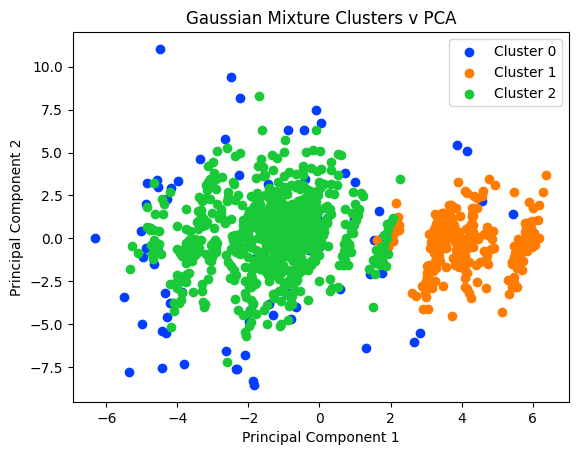

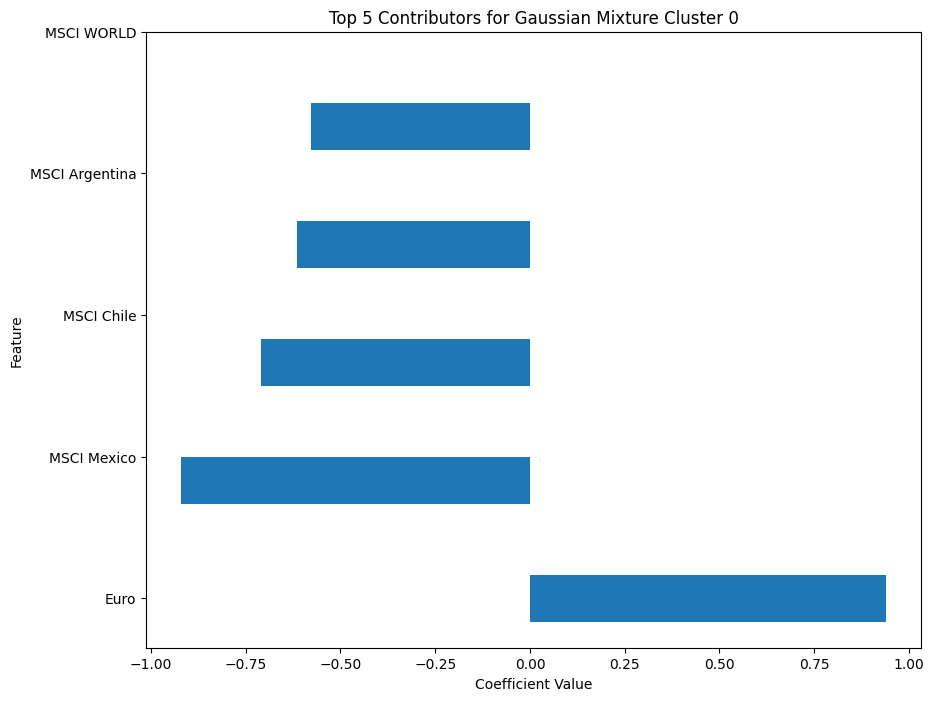

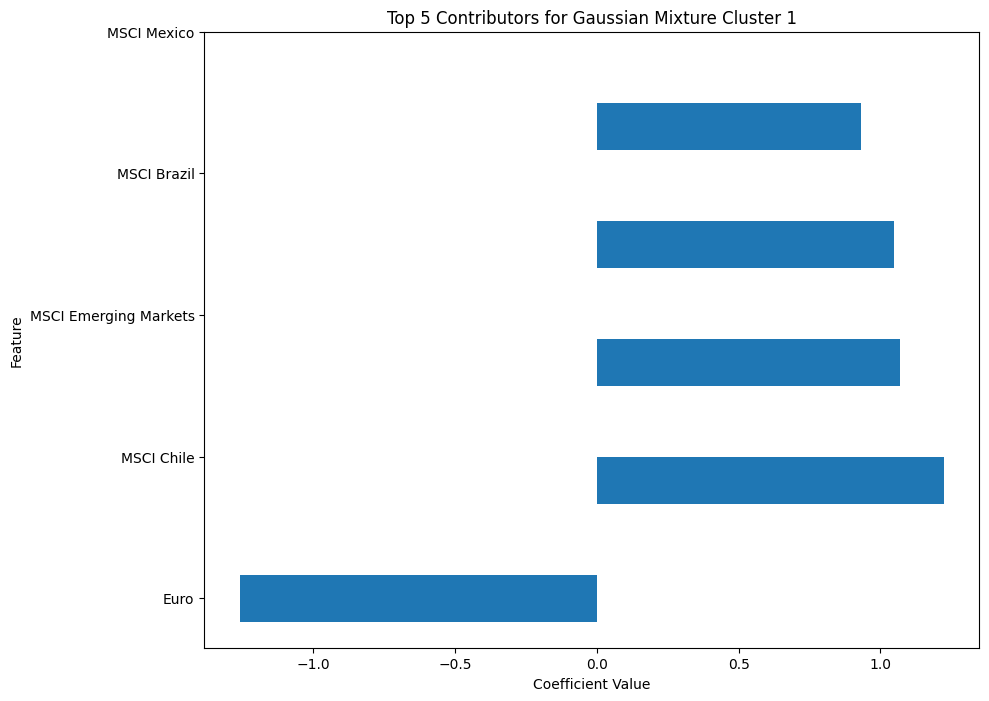

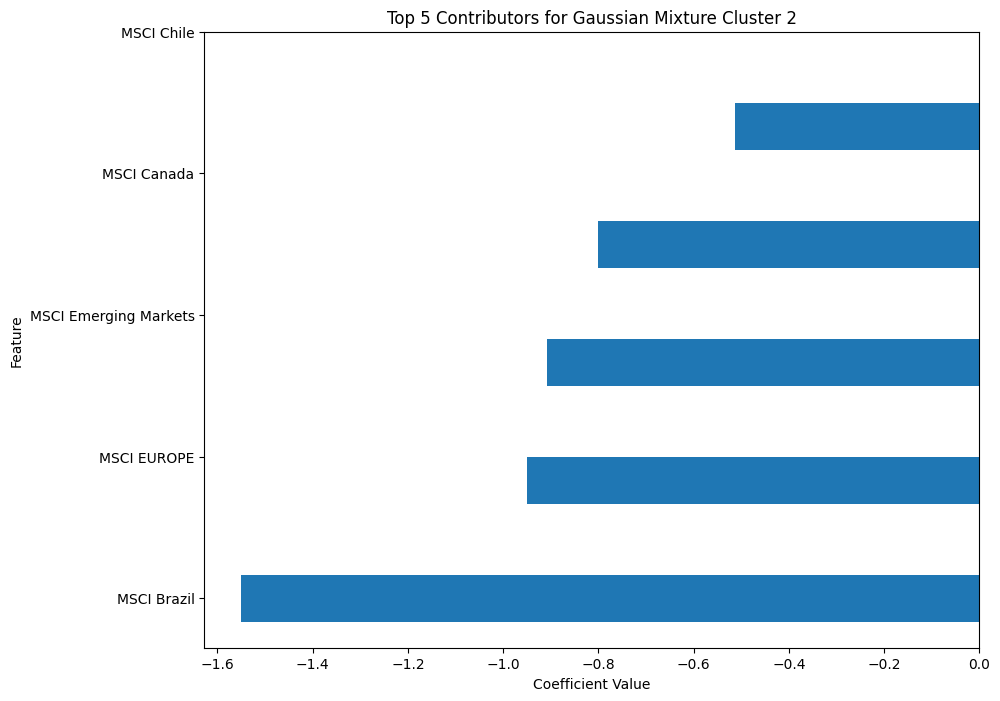

Accuracy: 0.46810506566604126


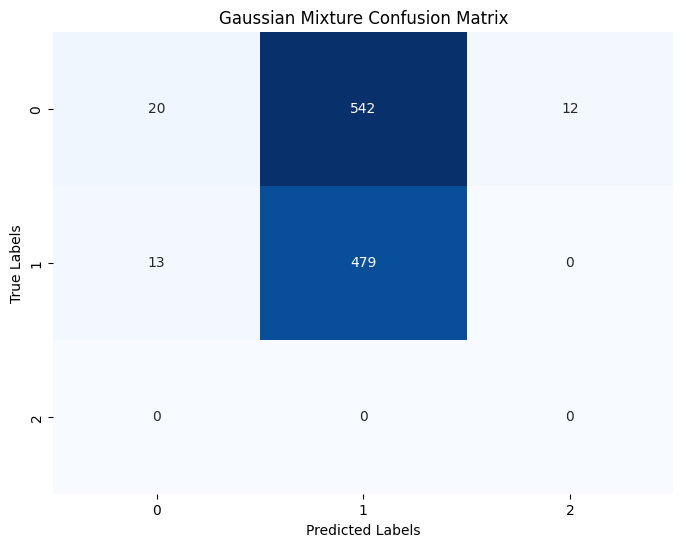

Mean Squared Error: 9079.272500678702


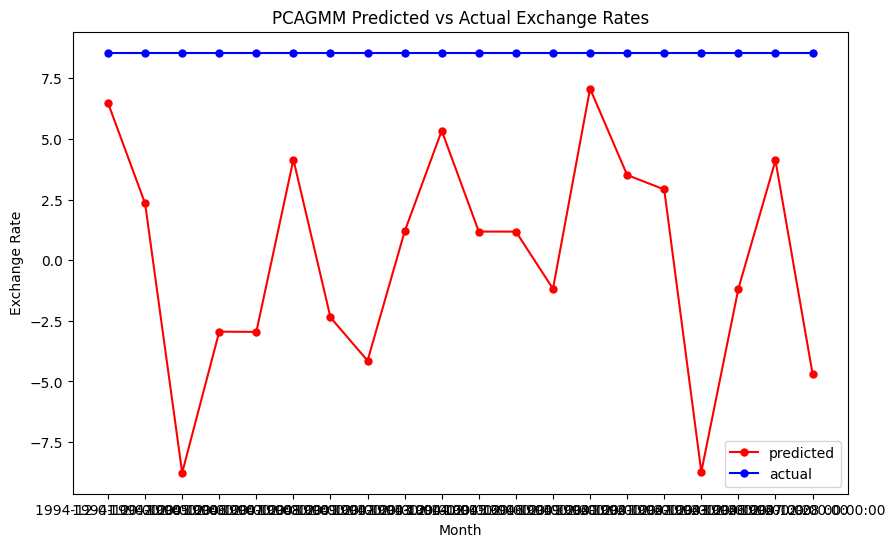

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
class PCAGMM():
    """Econometric style classifier.

    Args:
    dim_c (int): Number of clusters.
    dim_z (int): Dimension of observed data.
    dim_x (int): Dimension of latent space.
    """
    def __init__(self, dim_x, dim_z, dim_c):
      super(PCAGMM, self).__init__()
      self.x_means = pd.DataFrame()

      self.PCA = PCA(n_components = dim_z)
      self.GMM = GaussianMixture(n_components=dim_c, covariance_type='diag')
      self.scaler = StandardScaler()
      self.log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

    def train(self, x_train, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
      principal_components = self.PCA.fit_transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      cluster_assignments = self.GMM.fit_predict(principal_df.iloc[:, :])
      self.z_means = self.GMM.means_

      # Create a DataFrame with the original X training set and cluster assignments
      X_train_with_clusters = pd.concat([x_train, pd.Series(cluster_assignments, name='today_clusters')], axis=1)
      self.x_means = x_train.groupby(cluster_assignments).mean()
      self.x_means.fillna(0)

      scaled_data['today_clusters'] = cluster_assignments
      y = cluster_assignments[1:]
      self.log_reg.fit(scaled_data[:-1], y)
      coefficients = self.log_reg.coef_

      # Get unique cluster assignments
      unique_clusters = np.unique(cluster_assignments)
      palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

      # Plot data points for each cluster separately
      for cluster in unique_clusters:
          cluster_indices = cluster_assignments == cluster
          plt.scatter(principal_df['PC1'][cluster_indices], principal_df['PC2'][cluster_indices],
                      color=palette[cluster], label=f'Cluster {cluster}')

      plt.xlabel('Principal Component 1')
      plt.ylabel('Principal Component 2')
      plt.title('Gaussian Mixture Clusters v PCA')
      plt.legend()
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/latentspacePCAGMM.png")
      plt.show()


      # Plot coefficients for each cluster within a loop
      for i, coef in enumerate(coefficients):
        sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort based on absolute value
        sorted_coefficients = coef[sorted_indices]
        sorted_column_names = scaled_data.columns[sorted_indices]

        # Truncate after the top 10 contributors
        sorted_coefficients = sorted_coefficients[:dim_z]
        sorted_column_names = sorted_column_names[:dim_z]

        # Calculate figure size based on the number of features
        fig_height = max(8, len(sorted_column_names) * 0.4)
        plt.figure(figsize=(10, fig_height))  # Increase the figure size

        bar_height = 0.4  # Set a fixed bar height

        plt.barh(sorted_column_names, sorted_coefficients, height=bar_height)  # Set bar height
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.title('Top 5 Contributors for Gaussian Mixture Cluster {}'.format(i))

        # Adjust the y-axis ticks
        tick_positions = np.arange(len(sorted_column_names)) * 1.2
        plt.yticks(tick_positions, sorted_column_names)

        images_dir = '/content/drive/My Drive/Thesis/Images'
        plt.savefig(f"{images_dir}/PCAGMM_log_model_coefficients_cluster{i}.png")
        plt.show()

    def test(self, x_test, dim_x, dim_z, dim_c):
      scaled_data = pd.DataFrame(self.scaler.transform(x_test), index = x_test.index, columns = x_test.columns)
      principal_components = self.PCA.transform(scaled_data)
      column_names = [f'PC{i}' for i in range(1, dim_z + 1)]
      principal_df = pd.DataFrame(data=principal_components, columns=column_names)
      scaled_data['today_clusters'] = self.GMM.predict(principal_df.iloc[:, :])
      scaled_data['tomorrow_clusters'] = self.log_reg.predict(scaled_data)

      y_pred = np.array([self.x_means.iloc[i] for i in scaled_data['tomorrow_clusters']])
      accuracy = accuracy_score(scaled_data['today_clusters'], scaled_data['tomorrow_clusters'])
      print("Accuracy:", accuracy)
      # Compute confusion matrix
      conf_matrix = confusion_matrix(scaled_data['today_clusters'], scaled_data['tomorrow_clusters'])
      # Plot confusion matrix
      plt.figure(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
      plt.title("Gaussian Mixture Confusion Matrix")
      plt.xlabel("Predicted Labels")
      plt.ylabel("True Labels")
      images_dir = '/content/drive/My Drive/Thesis/Images'
      plt.savefig(f"{images_dir}/PCAGMMconfusion_matrix.png")
      plt.show()
      return y_pred

dim_c = 3
dim_z = 5
dim_x = X_train.shape[1]
# Instantiate PCAGMM_model and train/test
PCAGMM_model = PCAGMM(dim_x, dim_z, dim_c)
PCAGMM_model.train(X_train, dim_x, dim_z, dim_c)
y_pred = PCAGMM_model.test(X_test, dim_x, dim_z, dim_c)

# Calculate mean squared error
mse = mean_squared_error(X_test, y_pred)
pred_exchange_rates = X_test.iloc[:20, 2]
actual_exchange_rates = y_pred[:20, 2]

# Plotting the second graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_exchange_rates)),pred_exchange_rates, marker='o', color='red', markersize=5, linestyle='-',label = 'predicted')
plt.plot(range(len(pred_exchange_rates)), actual_exchange_rates, marker='o', color='blue', markersize=5, linestyle='-', label = 'actual')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.title('PCAGMM Predicted vs Actual Exchange Rates')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.xticks(range(len(pred_exchange_rates)), X_test.index[:20])
plt.savefig(f"{images_dir}/PCAGMMcomparisonpng")
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
plt.legend()
print("Mean Squared Error:", mse)



This code is the VaDE class and set-up.

In [ ]:
"""An implementation of VaDE(https://arxiv.org/pdf/1611.05148.pdf).
"""
import math

import torch
import torch.nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import tensorflow as tf


def _reparameterize(mu, logvar):
    """Reparameterization trick.
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    #print(z.shape)
    return z


class VaDE(torch.nn.Module):
    """Variational Deep Embedding(VaDE).

    Args:
        n_classes (int): Number of clusters.
        data_dim (int): Dimension of observed data.
        latent_dim (int): Dimension of latent space.
    """
    def __init__(self, dim_c, dim_x, dim_z):
        super(VaDE, self).__init__()

        self._pi = Parameter(torch.zeros(dim_c))
        self.mu = Parameter(torch.randn(dim_c, dim_z))
        self.logvar = Parameter(torch.randn(dim_c, dim_z))

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(dim_x, 50),
            torch.nn.Sigmoid(),
        )
        self.encoder_mu = torch.nn.Linear(50, dim_z)
        self.encoder_logvar = torch.nn.Linear(50, dim_z)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_z, 50),
            torch.nn.Linear(50, dim_x),
        )

    @property
    def weights(self):
        return torch.softmax(self._pi, dim=0)

    def lossweights(self, p):
        return torch.cat((torch.linspace(0, p, dim_x - 10),torch.linspace(0, 1 - p, 10)))

    def encode(self, x):
        h = self.encoder(x)
        mu = self.encoder_mu(h)
        logvar = self.encoder_logvar(h)
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = _reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def classify_means(self, x):
      x = x.view(-1, dim_x)

      # Compute gamma ( q(c|x) )
      mu, logvar = self.encode(x)  # Use self.encode() instead of model.encode()
      z = _reparameterize(mu, logvar)
      z = z.view(-1, dim_z)
      #print('z', z.shape)

      p_z_given_c = torch.zeros(batch_size, model.mu.shape[0])

      for i in range(batch_size):
        z_tensor = z[i].repeat(model.mu.shape[0], 1)
        h = z_tensor - model.mu
        h = torch.exp(-0.5 * torch.div(h * h, model.logvar.exp()))
        h = h / (math.sqrt(2 * math.pi) * model.logvar.exp() + 1e-9)
        p_z_given_c_i = torch.prod(h, dim=1)
        p_z_given_c[i] = p_z_given_c_i


      p_z_c = p_z_given_c * model.weights
      #print('probs', p_z_given_c.shape)
      #print('row sum', torch.sum(p_z_c, dim=1, keepdim=True))
      gamma = p_z_c / torch.sum(p_z_c, dim=1, keepdim=True)
      #print(torch.sum(gamma, dim = 0))
      pred = torch.argmax(gamma, dim=1)
      return pred

    def classify_time(self, x):
      #x = x.view(-1, dim_x)

      # Compute gamma ( q(c|x) )
      mu, logvar = self.encode(x)  # Use self.encode() instead of model.encode()
      z = _reparameterize(mu, logvar)
      z = z.view(-1, dim_z)
      #print('z', z.shape)

      p_z_given_c = torch.zeros(batch_size, model.mu.shape[0])
      #print('pzgiven c', p_z_given_c.shape)

      for i in range(batch_size-1):
        z_tensor = z[i].repeat(model.mu.shape[0], 1)
        h = z_tensor - model.mu
        h = torch.exp(-0.5 * torch.div(h * h, model.logvar.exp()))
        h = h / (math.sqrt(2 * math.pi) * model.logvar.exp() + 1e-9)
        p_z_given_c_i = torch.prod(h, dim=1)
        p_z_given_c[i] = p_z_given_c_i


      p_z_c = p_z_given_c * model.weights
      #print('probs', p_z_given_c.shape)
      #print('row sum', torch.sum(p_z_c, dim=1, keepdim=True))
      gamma = p_z_c / torch.sum(p_z_c, dim=1, keepdim=True)
      #print(torch.sum(gamma, dim = 0))
      pred = torch.argmax(gamma, dim=1)
      return pred

    def classify(self, x):
      #x = x.view(-1, dim_x)
      batch_size = x.shape[0]

      # Compute gamma ( q(c|x) )
      mu, logvar = self.encode(x)  # Use self.encode() instead of model.encode()
      z = _reparameterize(mu, logvar)
      z = z.view(-1, dim_z)
      #print('z', z.shape)

      p_z_given_c = torch.zeros(batch_size, model.mu.shape[0])
      #print('pzgiven c', p_z_given_c.shape)

      for i in range(batch_size-1):
        z_tensor = z[i].repeat(model.mu.shape[0], 1)
        h = z_tensor - model.mu
        h = torch.exp(-0.5 * torch.div(h * h, model.logvar.exp()))
        h = h / (math.sqrt(2 * math.pi) * model.logvar.exp() + 1e-9)
        p_z_given_c_i = torch.prod(h, dim=1)
        p_z_given_c[i] = p_z_given_c_i


      p_z_c = p_z_given_c * model.weights
      #print('probs', p_z_given_c.shape)
      #print('row sum', torch.sum(p_z_c, dim=1, keepdim=True))
      gamma = p_z_c / torch.sum(p_z_c, dim=1, keepdim=True)
      #print(torch.sum(gamma, dim = 0))
      pred = torch.argmax(gamma, dim=1)
      return pred

def lossfun(model, x, recon_x, mu, logvar, batch_size):
    # Compute reconstruction loss
    batch_size = x.shape[1]
    loss_weights = model.lossweights(p)

    # Compute gamma ( q(c|x) )
    z = _reparameterize(mu, logvar)
    z = z.view(batch_size, dim_z)

    p_z_given_c = torch.zeros(batch_size, model.mu.shape[0])

    for i in range(batch_size):
        z_tensor = z[i].repeat(model.mu.shape[0], 1)
        h = z_tensor - model.mu
        h = torch.exp(-0.5 * torch.div(h * h, model.logvar.exp()))
        h = h / (math.sqrt(2 * math.pi) * model.logvar.exp() + 1e-9)
        p_z_given_c_i = torch.prod(h, dim=1)
        p_z_given_c[i] = p_z_given_c_i

    p_z_c = p_z_given_c * model.weights
    gamma = p_z_c / torch.sum(p_z_c, dim=1, keepdim=True)

    mu_x = model.decode(z)
    recon = (x - mu_x).pow(2)
    recon /= batch_size

    # Compute total divergence
    mu = mu.view(batch_size, dim_z)
    logvar = logvar.view(batch_size, dim_z)
    total = torch.zeros(model._pi.shape[0])
    for c in range(dim_c):
        for z_idx in range(batch_size):
            h = (mu[z_idx] - model.mu[c]).pow(2) + logvar[z_idx].exp().pow(2)
            h = torch.sum(model.logvar[c] + torch.div(h, model.logvar[c].exp().pow(2)))
        total[c] = h


    # Compute loss components
    recon_loss = (recon.mean(dim=0) * loss_weights).sum()
    divergence_loss = 0.5 * torch.sum(gamma * total, dim=1)
    weights_loss = (torch.sum(gamma * torch.log(model.weights + 1e-9), dim=1)).sum()
    gamma_loss = (torch.sum(gamma * torch.log(gamma + 1e-9), dim=1) ).sum()
    kl_loss = (-0.5 * torch.sum(1 + logvar, dim=1)).sum()

    # Compute total loss
    loss = recon_loss + divergence_loss + weights_loss + gamma_loss + kl_loss
    loss /= batch_size
    loss = torch.sum(loss)

    return recon_loss, loss

class AutoEncoderForPretrain(torch.nn.Module):
    """Auto-Encoder for pretraining VaDE.

    Args:
        data_dim (int): Dimension of observed data.
        latent_dim (int): Dimension of latent space.
    """
    def __init__(self, dim_x, dim_z):
        super(AutoEncoderForPretrain, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(dim_x, 50),
            torch.nn.Sigmoid(),
        )
        self.encoder_mu = torch.nn.Linear(50, dim_z)

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim_z, 50),
            torch.nn.Linear(50, dim_x),
        )

    def encode(self, x):
        return self.encoder_mu(self.encoder(x))

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        recon_x = self.decode(z)
        return recon_x

import argparse

from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn.functional as F
import torch.utils.data
from torchvision import datasets, transforms
import torch.multiprocessing as mp

import matplotlib.pyplot as plt

def train(model, data_loader, optimizer, epochs):
  model.train()

  losses = []  # List to store loss values for each epoch

  for epoch in range(1, epochs + 1):
      total_loss = 0

      for x in data_loader:
          x = np.array(x)
          x = torch.from_numpy(x).float()
          recon_x = model(x)
          loss = torch.sum((recon_x - x).pow(2) / len(data_loader))  # Compute mean loss per batch
          total_loss += loss.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      avg_loss = total_loss / len(data_loader)
      losses.append(avg_loss)

      #print('Epoch {:>3}: Train Loss = {:.4f}'.format(epoch, avg_loss))

    # Plot all the epoch losses after all epochs have been completed
  plt.plot(range(1, epochs + 1), losses, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Pre Training Loss vs. Epoch')
  images_dir = '/content/drive/My Drive/Thesis/Images'
  plt.savefig(f"{images_dir}/initializing6.png")
  plt.grid(True)
  plt.show()


#torch.save(model.state_dict())
def trainVAE(model, data_loader, optimizer, writer):
    model.train()
    #print("training")
    #dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

    total_loss = 0
    for x in data_loader:
        x = np.array(x)
        x = torch.from_numpy(x).float()
        #print(x)

        recon_x, mu, logvar = model(x)
        #print("mu", mu.shape)
        #print(recon_x.shape)
        recon_loss, loss = lossfun(model, x, recon_x, mu, logvar, batch_size)
        total_loss += loss.item()
        #print(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #print("Total Loss", loss.item())
    writer.add_scalar('Loss/train', total_loss / len(data_loader), epoch)
    return mu, logvar, loss.item()

#def pred_loop(model, x, log_reg):


This is the main training loop.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


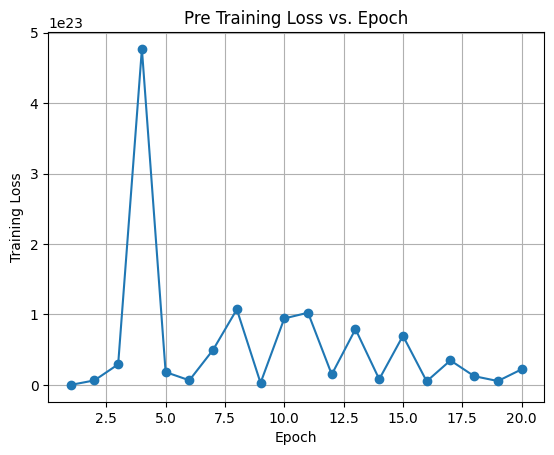

mu_z tensor([[-1067.9579,  -412.8153,  -186.9268,  -990.5874,  -922.1257],
        [-2248.3782,  -960.6747,  -183.3762, -2111.3293, -1717.6920],
        [-1641.4048,  -697.3336,  -215.5245, -1517.3812, -1299.8080]])
logvar_z tensor([[11.3439, 11.1854, 10.7385, 11.1572, 11.2252],
        [11.6132, 11.3779, 11.0124, 11.4554, 11.1454],
        [11.2312, 11.2617, 10.9737, 11.2137, 11.1315]])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


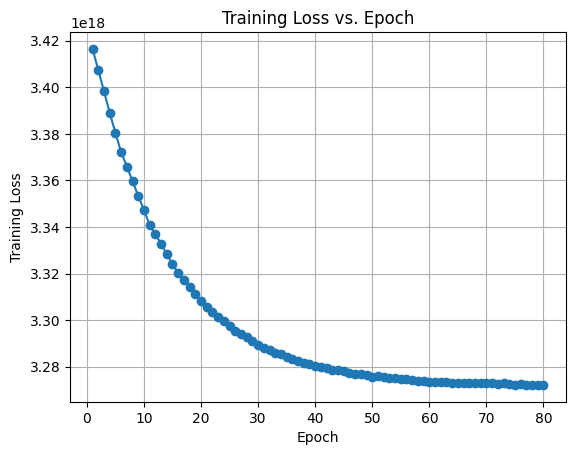

In [ ]:
import random


lr = 1e2
dim_c = 3
dim_z = 5
dim_x = X_train.shape[1]
#print(dim_x)
p = 0.95

dataset = train_dataset

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
        num_workers=1)
plot_points = {}

pretrain_model = AutoEncoderForPretrain(dim_x, dim_z)

optimizer = torch.optim.Adam(pretrain_model.parameters(),
                                 lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
for epoch in range(1):
    train(pretrain_model, data_loader, optimizer, 20)

with torch.no_grad():
    x = torch.cat([data[0] for data in dataset]).view(-1, dim_x)
    z = pretrain_model.encode(x)


state_dict = pretrain_model.state_dict()

nan_mask = torch.isnan(z)
z[nan_mask] = 0

gmm = GaussianMixture(n_components=dim_c, covariance_type='diag')
gmm.fit(z)

model = VaDE(dim_c, dim_x, dim_z)
model.load_state_dict(state_dict, strict=False)
model._pi.data = torch.log(torch.from_numpy(gmm.weights_)).float()
model.mu.data = torch.from_numpy(gmm.means_).float()
model.logvar.data = torch.log(torch.from_numpy(gmm.covariances_)).float()
torch.save(model.state_dict(), 'model_parameters.pth')

print('mu_z', model.mu.data)
print('logvar_z', model.logvar.data)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    # LR decreases every 3 epochs with a decay rate of 0.9
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

epochs = 80
    # TensorBoard
writer = SummaryWriter()
losses = []
mu_list = []
for epoch in range(1, epochs+1):
    mu, logvar, loss = trainVAE(model, data_loader, optimizer, writer)
    lr_scheduler.step()
    mu_list.append(model.mu.detach().numpy())
    #print("Epoch", epoch, "complete!")
    #print("Means_z", model.mu)
    #print("Logvar_z", model.logvar)
    losses.append(loss)

writer.close()
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epoch')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/training_loss5.png")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Drop the existing 'clusters' column if it already exists
if 'today_clusters' in returns_df.columns:
    returns_df = returns_df.drop(columns=['today_clusters'])
if 'tomorrow_clusters' in returns_df.columns:
    returns_df = returns_df.drop(columns=['tomorrow_clusters'])

clusters = model.classify(torch.from_numpy(returns_df.values).float())
clusters = clusters.detach().numpy()
returns_df['today_clusters']= clusters
returns_df['tomorrow_clusters'] = np.append(clusters[1:], 0)

# Save the concatenated DataFrame to an Excel file
returns_df.to_excel('/content/drive/My Drive/Thesis/output.xlsx', index=True)


Train the Logistic Regression.

Accuracy: 0.27793427230046946


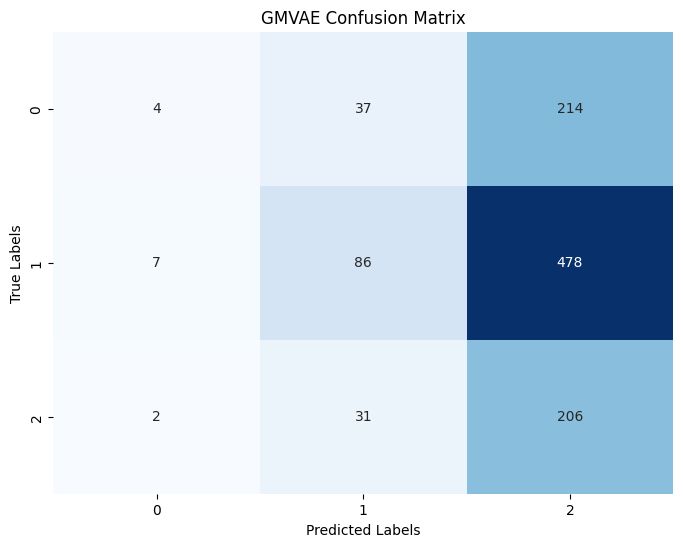

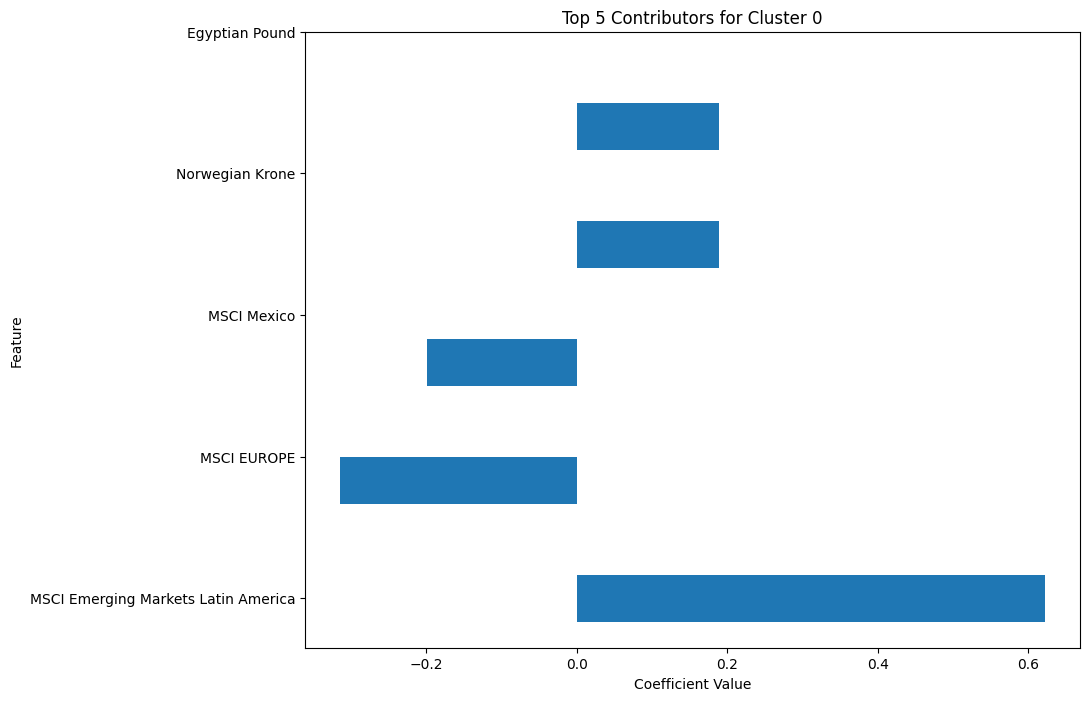

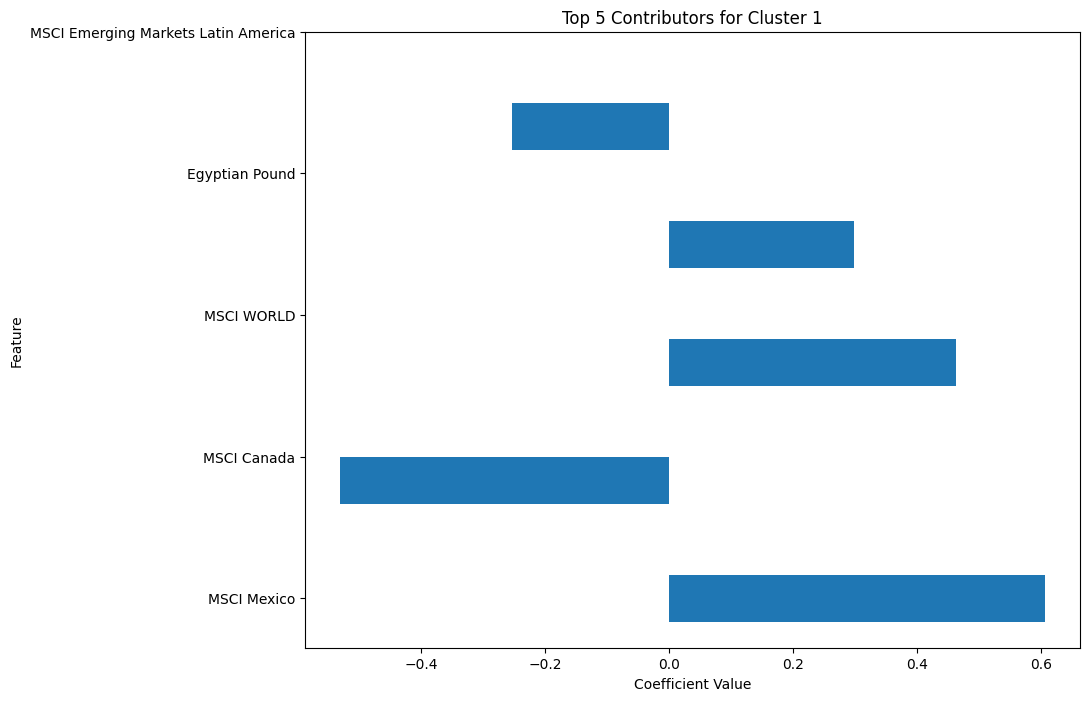

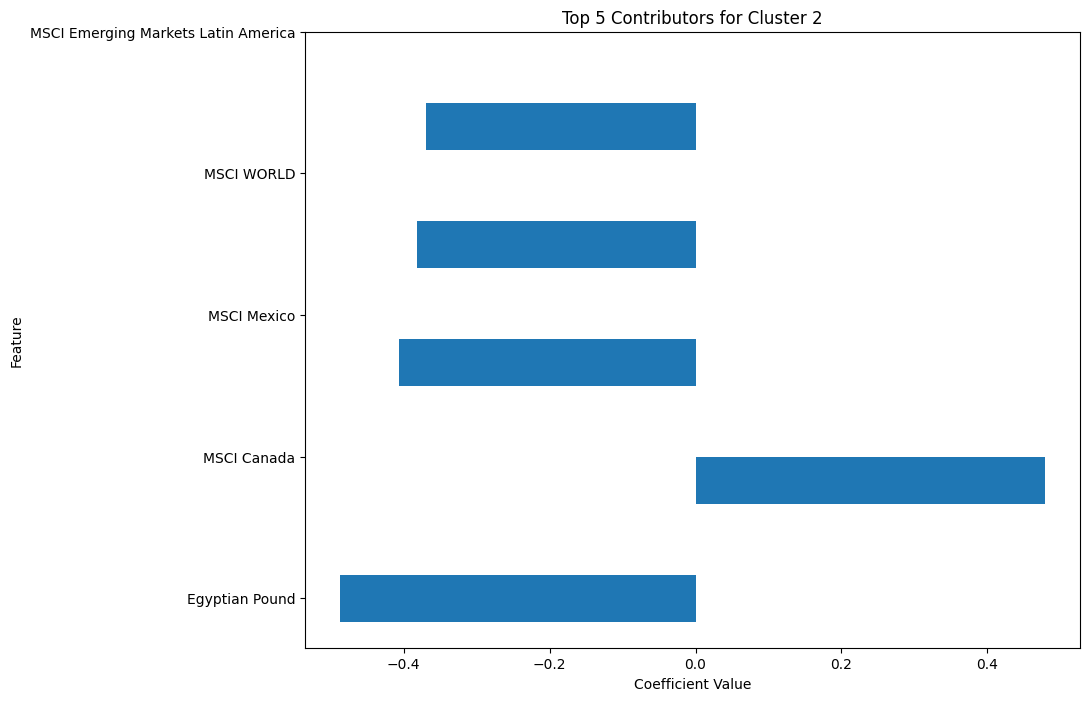

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'clusters' is the target column and 'features' are the predictor columns
X = returns_df.iloc[:-1,:-1] #frop tomorrow-clusters and the last row
y = returns_df['tomorrow_clusters'][:-1]

# Splitting the data into train and test sets
X_train = X[X.index < cutoff_date]
X_test = X[X.index >= cutoff_date]
y_train = y[y.index < cutoff_date]
y_test = y[y.index >= cutoff_date]

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multinomial Logistic Regression
GMVAE_log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
GMVAE_log_model.fit(X_train_scaled, y_train)
y_pred = GMVAE_log_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("GMVAE Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/GMVAEconfusion_matrix.png")
plt.show()

coefficients = GMVAE_log_model.coef_
intercept = GMVAE_log_model.intercept_

# Plot coefficients for each cluster within a loop
for i, coef in enumerate(coefficients):
    sorted_indices = np.argsort(np.abs(coef))[::-1]  # Sort based on absolute value
    sorted_coefficients = coef[sorted_indices]
    sorted_column_names = X.columns[sorted_indices]

    # Truncate after the top 10 contributors
    top_n = 5
    sorted_coefficients = sorted_coefficients[:top_n]
    sorted_column_names = sorted_column_names[:top_n]

    # Calculate figure size based on the number of features
    fig_height = max(8, len(sorted_column_names) * 0.4)
    plt.figure(figsize=(10, fig_height))  # Increase the figure size

    bar_height = 0.4  # Set a fixed bar height

    plt.barh(sorted_column_names, sorted_coefficients, height=bar_height)  # Set bar height
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 5 Contributors for Cluster {}'.format(i))

    # Adjust the y-axis ticks
    tick_positions = np.arange(len(sorted_column_names)) * 1.2
    plt.yticks(tick_positions, sorted_column_names)

    images_dir = '/content/drive/My Drive/Thesis/Images'
    plt.savefig(f"{images_dir}/GMVAE_log_model_coefficients_cluster{i}.png")
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

batch_size = 1066

# Switch color to gradient
clusters = model.classify_time(X_test_tensor)
clusters = clusters.detach().numpy()

# Define colormap
cmap = sns.color_palette("magma", as_cmap=True)

# Grouping clusters
group_size = 20
grouped_clusters = [clusters[i:i + group_size] for i in range(0, len(clusters), group_size)]
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::group_size]]

# Calculate cluster mean for each group
cluster_means = [np.mean(group) for group in grouped_clusters]
print(cluster_means)

# Plotting the first graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_means, marker='o', color='blue', markersize=5, linestyle='-')
plt.xlabel('Month')
plt.ylabel('Mean Cluster')
plt.title('Clustered Results From Each Month')
plt.xticks(range(len(cluster_means)), batch_indices[:len(cluster_means)], rotation='vertical')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/clusteredtime7.png")
plt.show()


Generate the MEANS ACROSS TIME graphic

total loss 1.3145706211035211e+20
total recon loss tensor(1.3146e+20, grad_fn=<AddBackward0>)
17
18


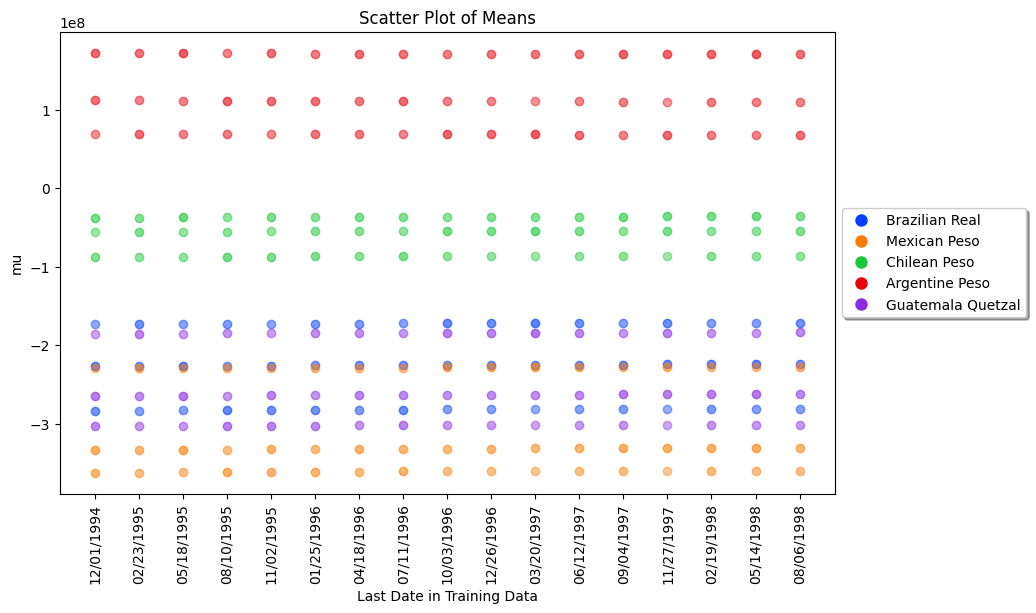

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is an instance of the VaDE model
# Assuming 'test_dataset' is your test dataset

batch_size = 60  # average number of weekdays in 4 months
test_dataset = torch.from_numpy(X_test.values).float()
test_dataset = TensorDataset(test_dataset)
# Create a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
# LR decreases every 3 epochs with a decay rate of 0.9
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Lists to store mu and logvar for each batch
mu_list = []
cluster_counts_list = []

# Iterate through batches in the test dataset
total_loss = 0
total_recon_loss = 0
for batch_data in test_loader:
    clusters = model.classify_means(x)
    cluster_counts = np.bincount(clusters, minlength=dim_c)
    cluster_counts_list.append(cluster_counts)

    x = np.array(batch_data)
    x = torch.from_numpy(x).float()

    recon_x, mu, logvar = model(x.float())
    recon_loss, loss = lossfun(model, x, recon_x, mu, logvar, batch_size)
    total_loss += loss.item()
    total_recon_loss+=(recon_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    loop = 30
    mu_accumulated = 0
    for i in range(loop):
        mu_accumulated += model.decode(model.mu.data)
    mu_batch = mu_accumulated / loop
    mu_list.append(mu_batch.detach().numpy())


print('total loss', total_loss)
print('total recon loss',total_recon_loss)
# Concatenate mu and logvar from all batches
mu_array = np.concatenate(mu_list, axis=0)

indices_of_interest = [2, 9, 17, 20, 24]
columns = [X_test.columns[i] for i in indices_of_interest]

# Define the color palette
palette = sns.color_palette("bright", len(indices_of_interest))

column_names = X_train.columns  # Use column names from X_train
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::batch_size]]

# Create a dictionary to map labels to colors
label_color_dict = {label: color for label, color in zip(columns, palette)}

plt.figure(figsize=(10, 6))
for i in range(len(mu_list)):
    # Get the mu values for the current batch
    mu_batch = mu_list[i]
    # Plot each column separately
    for j, color in zip(indices_of_interest, palette):
        x_values = np.full(len(mu_batch), i)
        y_values = mu_batch[:, j]

        normalized_counts = cluster_counts_list[i] / np.sum(cluster_counts_list[i])
        saturations = 0.3 + normalized_counts * 0.7

        # Check if y_values is empty before plotting
        for k in range(len(y_values)):
            plt.scatter(i, y_values[k], label=column_names[j], color=color, alpha=saturations[k])

print(len(mu_list))
print(len(batch_indices))

# Create a custom legend with only labels corresponding to indices of interest
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_dict[label], markersize=10) for label in columns]
plt.legend(handles, columns, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xticks(range(len(mu_list)), batch_indices[:-1], rotation='vertical')

plt.ylabel('mu')
plt.xlabel('Last Date in Training Data')
plt.title('Scatter Plot of Means')

# Save and display the plot
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/means_across_time8.png")
plt.show()


This code is used for the "Alternate Histories" Experiment. The first graph generated shows the predictions for the years 1996-1998, once the model has been trained on the 1994-1996 data. Meanwhile, the second graph generated ONLY trains the model on the 1996-1998 data. Comparing the graphs allows us to determine the impact on training the model on the data from 194-1996. As evidenced by the graphs, the model does learn from the Mexican Peso Crisis.

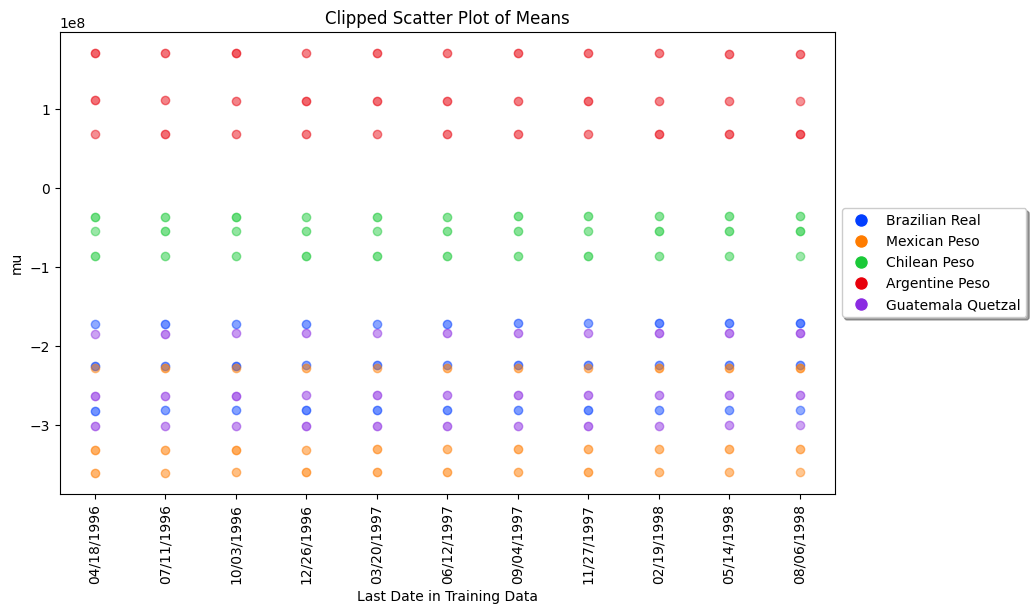

In [ ]:
#Clipped Means Across Time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is an instance of the VaDE model
# Assuming 'test_dataset' is your test dataset

mu_list = mu_list[6:]
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[6*batch_size::batch_size]]

# Create a dictionary to map labels to colors
label_color_dict = {label: color for label, color in zip(columns, palette)}
#print(len(mu_list))

plt.figure(figsize=(10, 6))
for i in range(len(mu_list)):
    # Get the mu values for the current batch
    mu_batch = mu_list[i]
    # Plot each column separately
    for j, color in zip(indices_of_interest, palette):
        x_values = np.full(len(mu_batch), i)
        y_values = mu_batch[:, j]

        normalized_counts = cluster_counts_list[i] / np.sum(cluster_counts_list[i])
        saturations = 0.3 + normalized_counts * 0.7
        for k in range(len(y_values)):
            plt.scatter(i, y_values[k], label=column_names[j], color=color, alpha=saturations[k])

# Create a custom legend with only labels corresponding to indices of interest
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_dict[label], markersize=10) for label in columns]
plt.legend(handles, columns, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xticks(range(len(mu_list)), batch_indices[:-1], rotation='vertical')

plt.ylabel('mu')
plt.xlabel('Last Date in Training Data')
plt.title('Clipped Scatter Plot of Means')

# Save and display the plot
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/clipped_means_across_time8.png")
plt.show()


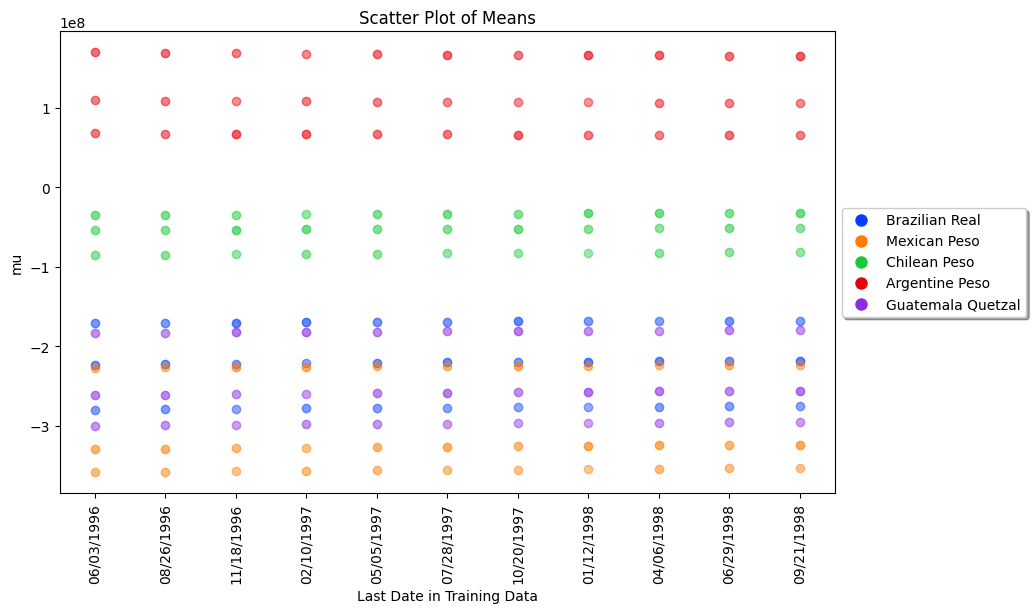

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is an instance of the VaDE model
# Assuming 'test_dataset' is your test dataset

batch_size = 60  # average number of weekdays in 4 months
test_dataset = torch.from_numpy(X_test_alt.values).float()
test_dataset = TensorDataset(test_dataset)

# Create a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-2)
# LR decreases every 3 epochs with a decay rate of 0.9
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Lists to store mu and logvar for each batch
mu_list = []
cluster_counts_list = []

# Iterate through batches in the test dataset
total_loss = 0
for batch_data in test_loader:
    clusters = model.classify_means(x)
    cluster_counts = np.bincount(clusters, minlength=dim_c)
    cluster_counts_list.append(cluster_counts)

    x = np.array(batch_data)
    x = torch.from_numpy(x).float()

    recon_x, mu, logvar = model(x.float())
    loss, recon_loss = lossfun(model, x, recon_x, mu, logvar, batch_size)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    loop = 30
    mu_accumulated = 0
    for i in range(loop):
        mu_accumulated += model.decode(model.mu.data)
    mu_batch = mu_accumulated / loop
    mu_list.append(mu_batch.detach().numpy())

# Concatenate mu and logvar from all batches
mu_array = np.concatenate(mu_list, axis=0)

indices_of_interest = [2, 9, 17, 20, 24]
columns = [X_test.columns[i] for i in indices_of_interest]

# Define the color palette
palette = sns.color_palette("bright", len(indices_of_interest))

column_names = X_train.columns  # Use column names from X_train
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test_alt.index[::batch_size]]

# Create a dictionary to map labels to colors
label_color_dict = {label: color for label, color in zip(columns, palette)}

plt.figure(figsize=(10, 6))
for i in range(len(mu_list)):
    # Get the mu values for the current batch
    mu_batch = mu_list[i]
    # Plot each column separately
    for j, color in zip(indices_of_interest, palette):
        x_values = np.full(len(mu_batch), i)
        y_values = mu_batch[:, j]

        normalized_counts = cluster_counts_list[i] / np.sum(cluster_counts_list[i])
        saturations = 0.3 + normalized_counts * 0.7

        # Check if y_values is empty before plotting
        for k in range(len(y_values)):
            plt.scatter(i, y_values[k], label=column_names[j], color=color, alpha=saturations[k])

# Create a custom legend with only labels corresponding to indices of interest
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_dict[label], markersize=10) for label in columns]
plt.legend(handles, columns, loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.xticks(range(len(mu_list)), batch_indices[:-1], rotation='vertical')

plt.ylabel('mu')
plt.xlabel('Last Date in Training Data')
plt.title('Scatter Plot of Means')

# Save and display the plot
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/means_across_time8.png")
plt.show()


Generate the Clustered Time Graph

probs torch.Size([1066, 3])
[1.15, 0.75, 1.0, 0.9, 0.35, 0.7, 0.95, 0.95, 1.15, 0.65, 1.05, 0.55, 0.9, 0.9, 0.75, 0.7, 1.1, 0.85, 0.65, 1.05, 0.8, 0.8, 1.45, 0.8, 1.0, 0.9, 1.05, 1.2, 0.75, 0.65, 1.1, 0.7, 0.75, 0.85, 1.05, 0.75, 0.9, 1.05, 1.05, 0.75, 0.75, 0.7, 1.0, 0.7, 0.9, 1.0, 0.75, 0.9, 0.95, 1.0, 0.8, 0.95, 0.9, 1.0]


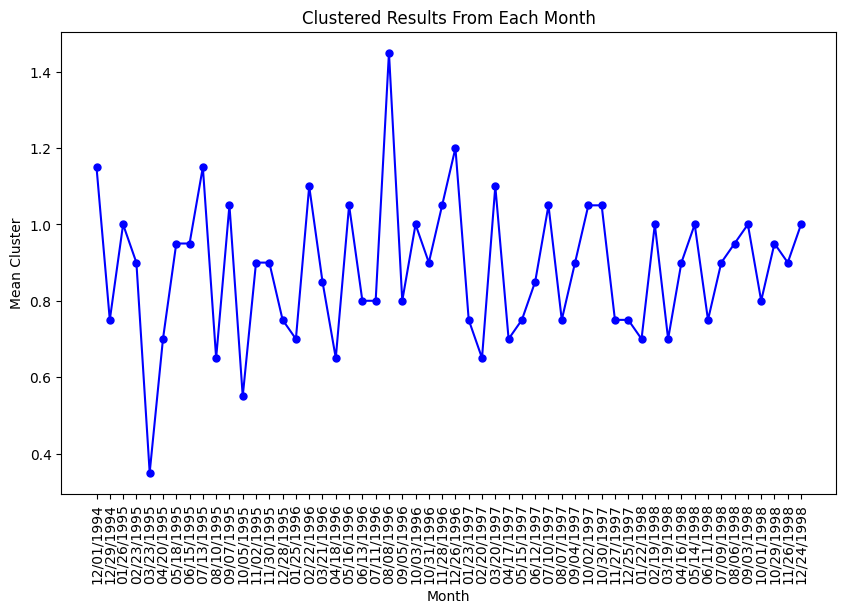

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

batch_size = 1066

# Switch color to gradient
clusters = model.classify_time(X_test_tensor)
clusters = clusters.detach().numpy()

# Define colormap
cmap = sns.color_palette("magma", as_cmap=True)

# Grouping clusters
group_size = 20
grouped_clusters = [clusters[i:i + group_size] for i in range(0, len(clusters), group_size)]
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::group_size]]

# Calculate cluster mean for each group
cluster_means = [np.mean(group) for group in grouped_clusters]
print(cluster_means)

# Plotting the first graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_means, marker='o', color='blue', markersize=5, linestyle='-')
plt.xlabel('Month')
plt.ylabel('Mean Cluster')
plt.title('Clustered Results From Each Month')
plt.xticks(range(len(cluster_means)), batch_indices[:len(cluster_means)], rotation='vertical')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/clusteredtime7.png")
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

batch_size = 1066

# Switch color to gradient
clusters = model.classify_time(X_test_tensor)
clusters = clusters.detach().numpy()

# Define colormap
cmap = sns.color_palette("magma", as_cmap=True)

# Grouping clusters
group_size = 20
grouped_clusters_4 = [clusters[i:i + group_size] for i in range(0, len(clusters), group_size)]
batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::group_size]]

# Calculate cluster mean for each group
cluster_means_4 = [np.mean(group) for group in grouped_clusters_4]

loss 557840.6610009011
Mean Squared Error: 9079.863233489621


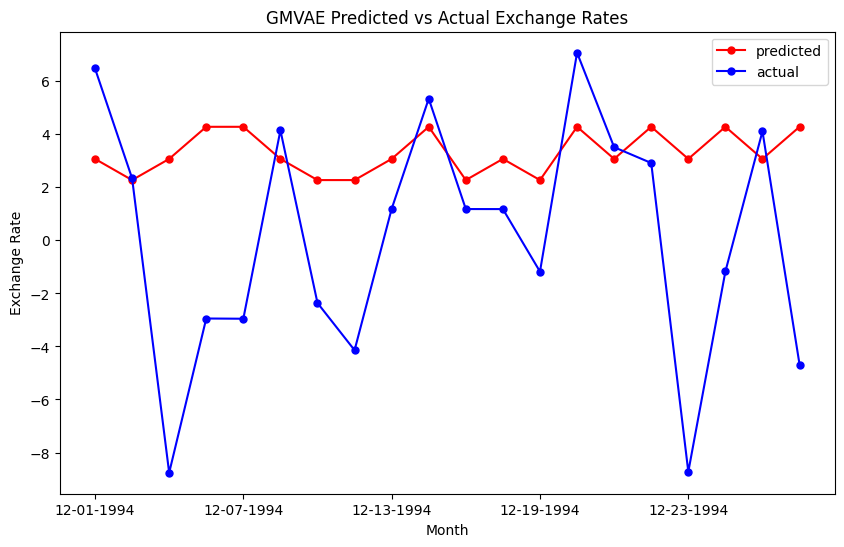

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mu_array = np.concatenate(mu_list, axis=0)
# Switch color to gradient
loss_mse = 0
cutoff = len(X_test)
clusters = model.classify(X_test_tensor)
clusters = clusters.detach().numpy()
for i in range(dim_x):
  mu_batch = mu_list[0]
  mu_batch = model.decode(model.mu).detach().numpy()
  actual_exchange_rates = X_test.iloc[:,i]

  #print(actual_exchange_rates)
  pred_exchange_rates = [-mu_batch[j][i]*2.25e-8 for j in clusters]
  loss_mse += mean_squared_error(actual_exchange_rates, pred_exchange_rates)
print('loss', loss_mse)

cmap = sns.color_palette("magma", as_cmap=True)

mu_batch = mu_list[0]
mu_batch = model.decode(model.mu).detach().numpy()
actual_exchange_rates = X_test.iloc[:20,2]

#print(actual_exchange_rates)
pred_exchange_rates = [-mu_batch[j][2]*1.25e-8 for j in clusters[:20]]

# Plotting the second graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_exchange_rates)),pred_exchange_rates, marker='o', color='red', markersize=5, linestyle='-', label = 'predicted')
plt.plot(range(len(pred_exchange_rates)), actual_exchange_rates, marker='o', color='blue', markersize=5, linestyle='-', label = 'actual')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.title('GMVAE Predicted vs Actual Exchange Rates')
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.xticks(range(len(pred_exchange_rates))[::4], X_test.index[:20:4].strftime("%m-%d-%Y"))
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
plt.legend()

print("Mean Squared Error:", mse)
plt.savefig(f"{images_dir}/GMVAEcomparison.png")
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
#plt.legend()

Plot the coordinates of the principal components for all points and vary the color by cluster assignment.

(1022, 2)
Explained variance ratio: [0.13075644 0.08449166]


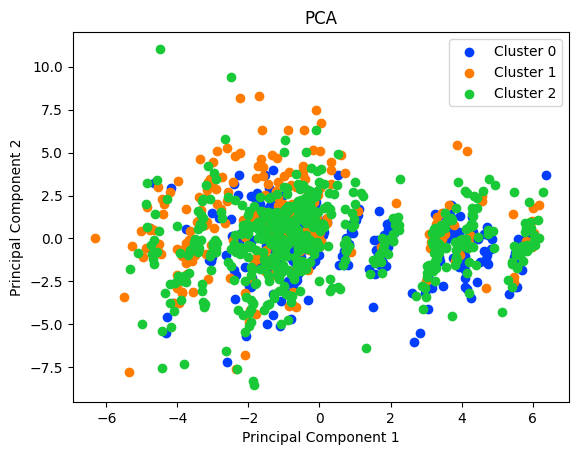

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Switch color to gradient
clusters = model.classify(X_train_tensor)
clusters = clusters.detach().numpy()

# Step 1: Preprocessing - Standardize the features by scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

# Step 2: PCA
pca = PCA(n_components=2)  # Specify the number of components you want to retain
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame to hold the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
print(principal_df.shape)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

unique_clusters = np.unique(clusters)
palette = sns.color_palette("bright", n_colors=len(unique_clusters))

# Plot data points for each cluster separately
for cluster in unique_clusters:
    cluster_indices = clusters == cluster
    plt.scatter(principal_df['PC1'][cluster_indices], principal_df['PC2'][cluster_indices], color=palette[cluster], label=f'Cluster {cluster}')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')

# You may need to create the directory if it doesn't exist
images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/latentspace7.png")
plt.legend()
plt.show()


Compare the errors

In [ ]:
# Plotting the second graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(pred_exchange_rates)),pred_exchange_rates, marker='o', color='red', markersize=5, linestyle='-')
plt.plot(range(len(pred_exchange_rates)), actual_exchange_rates, marker='o', color='blue', markersize=5, linestyle='-')
plt.xlabel('Month')
plt.ylabel('Exchange Rate')
plt.title('Predicted vs Actual Exchange Rates')
#plt.xticks(range(len(pred_exchange_rates)), batch_indices[:len(pred_exchange_rates)], rotation='vertical')
#plt.legend()

images_dir = '/content/drive/My Drive/Thesis/Images'
plt.savefig(f"{images_dir}/ClusteredtimeExchange1.png")
plt.show()

'''# Grouping clusters
group_size = 20
grouped_clusters = [clusters[i:i + group_size] for i in range(0, len(clusters), group_size)]
#batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::group_size]]

# Calculate cluster mean for each group
cluster_means = [np.mean(group) for group in grouped_clusters]
print(cluster_means)
cluster_means_int = np.array(cluster_means).astype(int)
mu_batch = mu_list[-1]
pred_exchange_rates = [mu_batch[i][2] for i in cluster_means_int]
print(cluster_means_int)


# Prepare data for the second plot

grouped_rates = [X_test[i:i + group_size] for i in range(0, len(X_test), group_size)]
#batch_indices = [dt.strftime('%m/%d/%Y') for dt in X_test.index[::group_size]]
actual_exchange_rates = [np.mean(group) for group in grouped_rates]
'''